In [ ]:
!unzip realsense_overhead.zip

unzip:  cannot find or open realsense_overhead.zip, realsense_overhead.zip.zip or realsense_overhead.zip.ZIP.


In [ ]:
!unzip /content/drive/MyDrive/realsense_overhead.zip

Archive:  /content/drive/MyDrive/realsense_overhead.zip
   creating: realsense_overhead/
  inflating: __MACOSX/._realsense_overhead  
  inflating: realsense_overhead/dish_1560455399.png  
  inflating: realsense_overhead/dish_1558382263.png  
  inflating: realsense_overhead/dish_1559668016.png  
  inflating: realsense_overhead/dish_1564590254.png  
  inflating: realsense_overhead/dish_1565194852.png  
  inflating: realsense_overhead/dish_1561740411.png  
  inflating: realsense_overhead/dish_1561145732.png  
  inflating: realsense_overhead/dish_1558375833.png  
  inflating: realsense_overhead/dish_1563910708.png  
  inflating: realsense_overhead/dish_1559844683.png  
  inflating: realsense_overhead/dish_1562873838.png  
  inflating: realsense_overhead/dish_1558115825.png  
  inflating: realsense_overhead/dish_1558381742.png  
  inflating: realsense_overhead/dish_1558549413.png  
  inflating: realsense_overhead/dish_1568048053.png  
  inflating: realsense_overhead/dish_1558116486.png  
  

In [ ]:
!ls

nutrition_data.csv  realsense_overhead.zip  sample_data


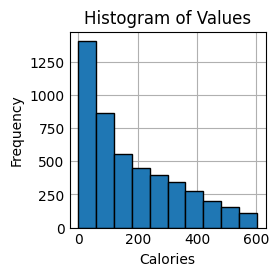

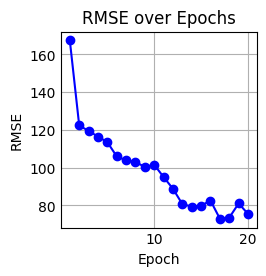

# New Section

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
from PIL import Image
import os
import random
import numpy as np

# 1. Dataset Class
class FoodDataset(Dataset):
    def __init__(self, root_dir, metadata_csv, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(metadata_csv, header=None, usecols=range(8))  # Load only first 8 columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dish_id = self.data.iloc[idx].iloc[0]
        calories = self.data.iloc[idx].iloc[1]  # Adjust if needed based on actual column name

        img_path = f"{self.root_dir}{dish_id}.png"
        if not os.path.isfile(img_path):
            image = Image.new("RGB", (225, 225), (0, 0, 0))  # Black image
            return self.transform(image), torch.tensor(np.nan)  # NaN as an invalid label
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(calories, dtype=torch.float32)

# Example usage:
dataset_path = r"realsense_overhead/"
metadata_path = r"nutrition_data.csv"

# Define configurations
config = {
        'learning_rate': 0.001,
        'batch_size': 64,
        'num_epochs': 50,
        'dropout_rate': 0.3,
        'optimizer': 'AdamW',
        'transform': transforms.Compose([
            transforms.Resize((225, 225)),
            transforms.ToTensor(),
        ]),
    }

best_config = None
best_mae = float('inf')
best_rmse = float('inf')

transform = config['transform']
dataset = FoodDataset(dataset_path, metadata_path, transform=transform)
indices = list(range(len(dataset)))
random.shuffle(indices)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

model = models.resnet50(weights=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(config['dropout_rate']),
    nn.Linear(512, 1)
)

criterion = nn.L1Loss()
if config['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
elif config['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(config['num_epochs']):
    model.train()
    running_loss = 0.0
    valid_batches = 0
    for images, labels in train_loader:
        mask = ~torch.isnan(labels)
        images, labels = images[mask], labels[mask]

        if len(labels) == 0:
            continue

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        if torch.isnan(loss):
            continue
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        valid_batches += 1

    # scheduler.step()

    if valid_batches > 0:
        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Loss: {running_loss/valid_batches:.4f}")

model.eval()
mae, mse, count = 0.0, 0.0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        mask = ~torch.isnan(labels)
        if mask.sum() == 0:
            continue

        images, labels = images[mask], labels[mask]

        outputs = model(images).squeeze()
        mae += torch.abs(outputs - labels).sum().item()
        mse += torch.sum((outputs - labels) ** 2).item()
        count += labels.size(0)

mae /= count
rmse = np.sqrt(mse / count)

print(f"Config: {config}, Test MAE: {mae:.2f}, Test RMSE: {rmse:.2f}, Test MSE: {mse:.2f}")

# Load and preprocess the new images
image_paths = [
    "/pub/yichx14/realsense_overhead/dish_1556575273.png",
    "/pub/yichx14/realsense_overhead/dish_1557861216.png",
    "/pub/yichx14/realsense_overhead/dish_1557862696.png",
    "/pub/yichx14/realsense_overhead/dish_1576183111.png",
    "/pub/yichx14/realsense_overhead/dish_1575478635.png"
]

# Load the labels from the CSV file
labels_df = pd.read_csv(metadata_path, header=None, usecols=range(8))
labels_dict = {str(row[0]) + ".png": row[1] for _, row in labels_df.iterrows()}

for img_path in image_paths:
    try:
        img = Image.open(img_path).convert("RGB")
        img = config['transform'](img).unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            prediction = model(img).item()

            # Extract the image ID from the path
            image_id = os.path.basename(img_path)

            # Get the true label from the dictionary
            true_label = labels_dict.get(image_id)

            if true_label is not None:
                print(f"Image: {img_path}, Predicted: {prediction:.2f}, True: {true_label}")
            else:
                print(f"Image: {img_path}, Predicted: {prediction:.2f}, True: Label not found")

    except FileNotFoundError:
        print(f"Error: Image file not found: {img_path}")
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 50.12 MiB is free. Process 14055 has 14.69 GiB memory in use. Of the allocated memory 12.85 GiB is allocated by PyTorch, and 1.71 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)